***POV: You just fked up a very important test but still have to do these stupid ass labs just like nothing happened $\mathbb{T \omega T}$***

In [439]:
import numpy as np
import matplotlib.pyplot as plt 

**(1)** Реализовать сигнал с единичными выбросами. Реализовать метод для исключения
выбросов в сигнале через порог стандартного отклонения. Представить очищенный сигнал.

In [2]:
def spiky_nd(A, degree):
    return np.abs(np.random.normal()**degree) * A

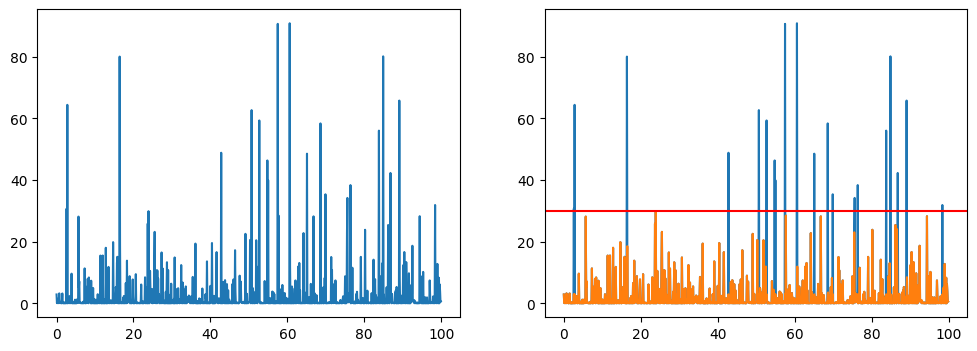

In [3]:
spiky_nd_time = np.arange(0, 100, 0.1)
spiky_nd_values = [spiky_nd(1, 4) for t in spiky_nd_time]



threshold = np.mean(spiky_nd_values) + 3 * np.std(spiky_nd_values)

spiky_nd_values_filtered = np.where(
    np.abs(spiky_nd_values) > threshold, np.mean(spiky_nd_values), spiky_nd_values
)


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(spiky_nd_time, spiky_nd_values)

plt.subplot(1, 2, 2)
plt.plot(spiky_nd_time, spiky_nd_values)
plt.plot(spiky_nd_time, spiky_nd_values_filtered)
plt.axhline(threshold, color='red')

plt.show()

<!-- ### –ноут (24-12-14) -->

**(2)** Реализовать сигнал, который содержит области с высоким уровнем шума. Это может быть
сделано путем добавления случайного шума к основному сигналу в определенных интервалах времени.

In [357]:
def funky_sinus(t, k, s, A):
    # return np.sin(t)*A
    np.random.seed(s + int(t//k))
    norm = np.random.normal(-A, A)
    np.random.seed()
    return norm + np.sin(s-t)

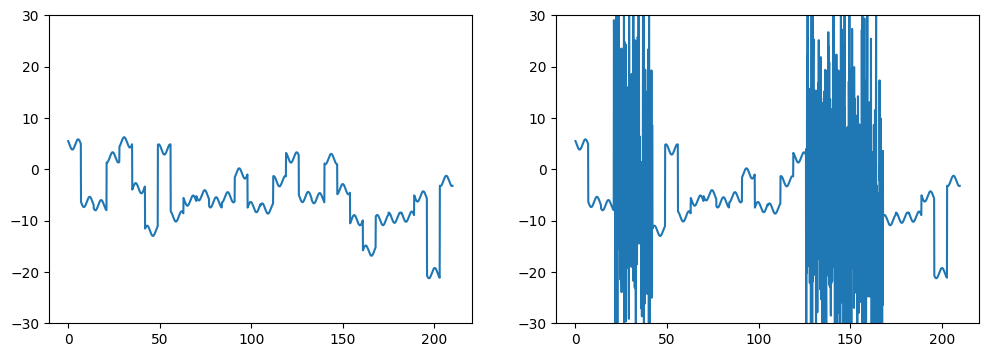

In [413]:
signal_time = np.arange(0, 210, 0.1)
signal_values = [funky_sinus(t, 7, 7, 7) for t in signal_time]

# А вот и наш зашумлённый сигнал!
signal_values_noisy = (
    signal_values[:int(0.1*len(signal_time))] +
    [t + np.random.normal(0, 17) for t in signal_values[int(0.1*len(signal_time)):int(0.2*len(signal_time))]] +
    signal_values[int(0.2*len(signal_time)):int(0.6*len(signal_time))] +
    [t + np.random.normal(0, 17) for t in signal_values[int(0.6*len(signal_time)):int(0.8*len(signal_time))]] +
    signal_values[int(0.8*len(signal_time)):]
)


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.ylim(-30, +30)
plt.plot(signal_time, signal_values)

plt.subplot(1, 2, 2)
plt.ylim(-30, +30)
plt.plot(signal_time, signal_values_noisy)

plt.show()

Напишите метод для очистки сигнала выше с помощью оконного скользящего
среднеквадратичного отклонения (Outlier time windows via sliding RMS). *Код, кстати, из лекции, хехе…*

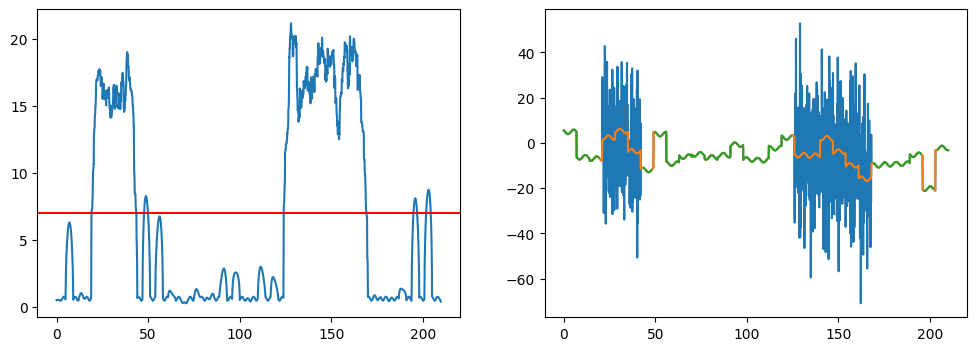

In [420]:
rms_window = 2 # Окно в процентах от времени
rms_window_idx = len(signal_time) * (rms_window / (2*100)) # Переводим окно в список индексов

# Инициализация вектора временного ряда RMS
rms_ts = np.zeros(len(signal_time))

# Проходимся окном по всему сигналу, определяем среднее  
for t_i in range(0, len(signal_time)):
    # Определяем индексы окна
    lb = int(np.max((0, int(t_i - rms_window_idx))))
    ub = int(np.min((len(signal_time), int(t_i + rms_window_idx))))

    # Считаем среднеквадратичное отклоение
    tmpsig = signal_values_noisy[lb:ub]
    tmpsig = tmpsig - np.mean(tmpsig)
    rms_ts[t_i] = np.sqrt(np.sum(tmpsig**2) / len(tmpsig))

thresh = 7 # Подбираем порог "на глаз"


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(signal_time, rms_ts)
plt.axhline(thresh, color='red')


# Вычисляем значения, отрезаемые порогом, и на их основе оставляем только "хорошие" значения
rms_ts_thresh = list(map(lambda a: a if a <= thresh else None, rms_ts))
signal_values_noisy_thresh = list(map(
    lambda i: signal_values_noisy[i] if rms_ts_thresh[i] is not None else None, range(len(rms_ts))
))


plt.subplot(1, 2, 2)
plt.plot(signal_time, signal_values_noisy)
plt.plot(signal_time, signal_values)
plt.plot(signal_time, signal_values_noisy_thresh)

plt.show()

Продолжаем мучить этот же сигнал:

**(3)** — Используя **метод спектральной интерполяции**, примерно восстановим вырезанные выше "плохие" части сигнала с удалёнными зашумлениями выше.

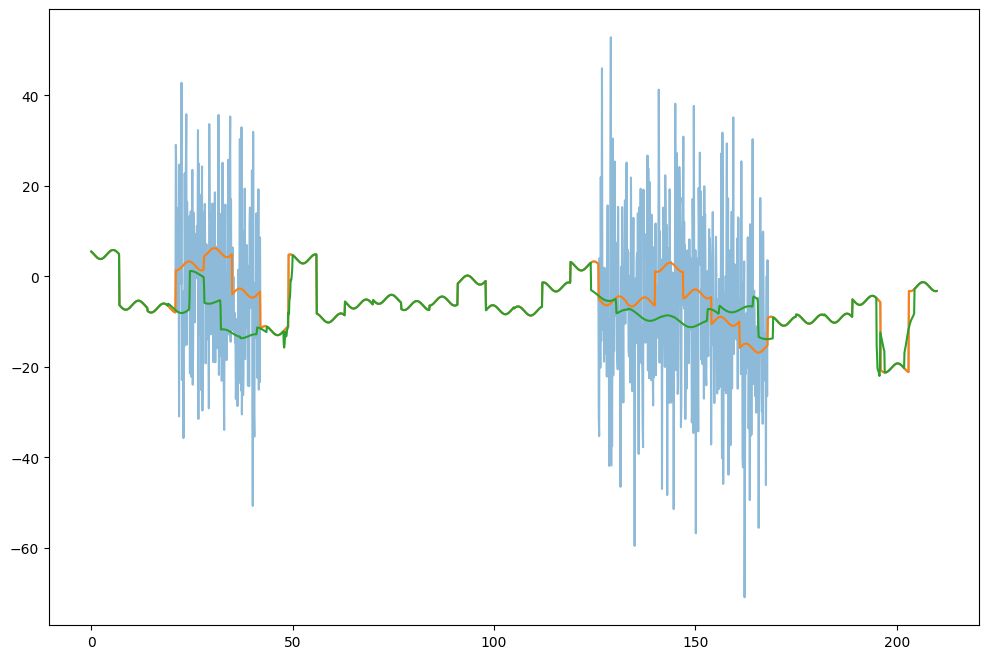

In [438]:
signal_values_restored = signal_values_noisy_thresh.copy()

si_window_size = 99  # Максимальный размер окна для анализа
si_corruption_start_idx = -1  # -1 если вне повреждённой части, иначе индекс начала повреждения

for i in range(len(signal_values_restored)):
    # Шаг 1: Найти индексы начала и конца разрыва сигнала
    if signal_values_restored[i] is None:
        if si_corruption_start_idx == -1:
            si_corruption_start_idx = i  # Начало разрыва
    else:
        if si_corruption_start_idx != -1:
            # Конец разрыва
            gap_start = si_corruption_start_idx
            gap_end = i
            si_corruption_start_idx = -1  # Сбрасываем индекс разрыва

            # Шаг 2: Определяем окна до и после разрыва
            left_start = max(0, gap_start - si_window_size)
            left_end = gap_start
            right_start = gap_end
            right_end = min(len(signal_values_restored), gap_end + si_window_size)

            left_window = signal_values_restored[left_start:left_end]
            right_window = signal_values_restored[right_start:right_end]

            # Удаляем None и обрезаем окна по первому None
            left_clean = [val for val in left_window if val is not None]
            right_clean = [val for val in right_window if val is not None]

            # Обрезаем по минимальной длине
            min_len = min(len(left_clean), len(right_clean))
            left_clean = np.array(left_clean[:min_len])
            right_clean = np.array(right_clean[:min_len])

            # Шаг 3: FFT и усреднение спектров
            left_spectrum = np.fft.fft(left_clean)
            right_spectrum = np.fft.fft(right_clean)
            avg_spectrum = np.add(left_spectrum, right_spectrum)

            # Восстановление через IFFT
            restored_signal = np.fft.ifft(avg_spectrum).real
            if left_window[-1] < right_window[0]:
                restored_signal = np.flip(restored_signal)

            # Шаг 4: Линейная интерполяция
            interp_indices = np.linspace(0, len(restored_signal) - 1, gap_end - gap_start)
            restored_gap = np.interp(interp_indices, np.arange(len(restored_signal)), restored_signal)
            restored_gap = np.add(restored_gap, np.linspace(left_window[-1], right_window[0], gap_end - gap_start)) / 2

            # Заполняем восстановленные значения в сигнал
            signal_values_restored[gap_start:gap_end] = restored_gap


plt.figure(figsize=(12, 8))

plt.plot(signal_time, signal_values_noisy, alpha=0.5)
plt.plot(signal_time, signal_values)
plt.plot(signal_time, signal_values_restored)

plt.show()

[*«День уже минає, наступає ніч»*](https://www.youtube.com/watch?v=cMMKv51HbbU)

# TODO: ~~**(3)**,~~ **(4)**.